In [131]:
import pandas as pd
from matplotlib import pyplot
import datetime
from sklearn.utils import resample
import statsmodels.api as sm
import os

In [137]:
# Set working dir
os.chdir("/Users/ishitagopal/Box/Stats_597_Project/")
os.getcwd()

'/Users/ishitagopal/Box/Stats_597_Project'

In [2]:
# force Pandas to not truncate the dataframe when printing 
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [135]:
# Read in the data 

# feautures in the training dataset
train_features = pd.read_csv("TrainData.csv")

# class labels for training dataset

train_lables = pd.read_csv("TrainLabels.csv")

# merging features with lables -- final training dataset 
df_train = train_features.merge(train_lables, on = 'id')

In [139]:
df_test = pd.read_csv("TestData.csv")

In [140]:
df_test.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [17]:
# feature names 
df_train.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [18]:
# there are no duplicates
df_train.duplicated().sum()

0

In [19]:
# number of records/observations and features
df_train.shape # (59400, 41)

# columns which have null values 
null_cols = df_train.columns[df_train.isnull().any(axis=0)]

#null_cols

#number of missing observations in each of the above column
df_train[null_cols].isnull().sum()

# Cross tabulating some variables -- status_group
##pd.crosstab(df_train['status_group'],df_train['quality_group'])

funder                3635
installer             3655
subvillage             371
public_meeting        3334
scheme_management     3877
scheme_name          28166
permit                3056
dtype: int64

### Features to be used in the Logistic Regression

id: pump id                                                            -- identifier

amount_tsh : Total static head (amount water available to waterpoint)  -- integer

gps_height : Altitude of the well                                      -- integer

#longitude, latitude: GPS coordinates

basin: Geographic water basin                                          -- 9 categories

region: Geographic location                                            -- 21 categories

#district_code: Geographic location (coded)

#lga : Geographic location

population: Population around the well                                   -- integer

permit: If the waterpoint is permitted                                   -- 2 categories

extraction_type_group: The kind of extraction the waterpoint uses        -- 13 categories

management: How the waterpoint is managed                                -- 12 categories

payment_type:  What the water costs                                      -- 7 categories

quality_group: The quality of the water                                  -- 6 categories

quantity: The quantity of water                                          -- 5 categories

source: The source of the water                                          -- 10 categories

status_group: target label 

### Discarded Features 

date_recorded: The date the row was entered -- there are essentially 2 main years 2011, 2013 when most of the records were made -- 5 years in total with 2012 having only 1 value 

wpt_name : Name of the waterpoint if there is one  -- not useful
 
num_private: no description  

region_code: Geographic location (coded) --  this doesn't mathc the region variable -- similar

ward  -- there were 1978 items in this category 

recorded_by -- has the same value for all the rows 

public_meeting -- not sure what this variable is 

waterpoint_type --  has many 0s in crosstabulations


### Features which may be useful but are problematic

'funder' , 'installer'            -- too many sub categories (there are 1822 unique funders                                                out of which 1433 have funded 10 or less pumps)

subvillage                        -- has 18148 unique categories 

construction_year                 -- has a category '0' with 18000 records (8978, 7569, 1453)

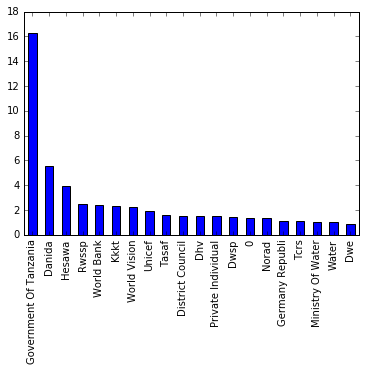

In [20]:
# https://www.analyticsvidhya.com/blog/2015/11/easy-methods-deal-categorical-variables-predictive-modeling/
series = pd.value_counts(df_train.funder)

# % of each of the sub-category
sub = (series/series.sum() * 100)
# sub-categories which have instances greater than 1
sub[0:20].plot(kind = 'bar')


### Similar Variables -- should choose one from each of these 

extraction  = 'extraction_type','extraction_type_group','extraction_type_class'

management =  'management', 'management_group'

payment ='payment', 'payment_type'                                  # these look the same 

water quality = 'water_quality', 'quality_group'

quantity = 'quantity', 'quantity_group'                      # these look exactly the same 

source = 'source', 'source_type', 'source_class'

waterpoint_type = 'waterpoint_type', 'waterpoint_type_group'

scheme = 'scheme_management', 'scheme_name'

In [21]:
# Check the number of null values across the three main class labels 

# -- create df with true-false assignments for missing values
# -- group the df by the three status labels 
# -- sum across the rows for each of those groups 
# -- display only columns which have null values 

cols = df_train.columns
df_train.isnull().groupby(df_train['status_group']).sum()[null_cols]



,funder,installer,subvillage,public_meeting,scheme_management,scheme_name,permit
status_group,,,,,,,
functional,1981.0,2000.0,205.0,1678.0,1873.0,14488.0,1673.0
functional needs repair,437.0,440.0,1.0,156.0,223.0,2004.0,300.0
non functional,1217.0,1215.0,165.0,1500.0,1781.0,11674.0,1083.0


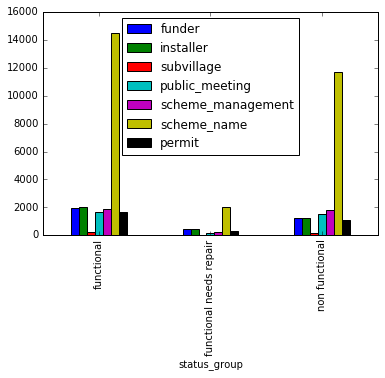

In [22]:
%matplotlib inline

# Plotting missing values 

df_train.isnull().groupby(df_train['status_group']).sum()[null_cols].plot(kind='bar')

##scheme name seems most problematic for all three categories 

In [23]:
# The feature 'scheme_name' seems to have the maximum missing values in all 3 categoreies 
# -- we will drop this variable
# -- we drop scheme_management   -- similar to management 
# -- we drop public_meeting

df_train = df_train.drop(['scheme_name','scheme_management','public_meeting'], axis=1)


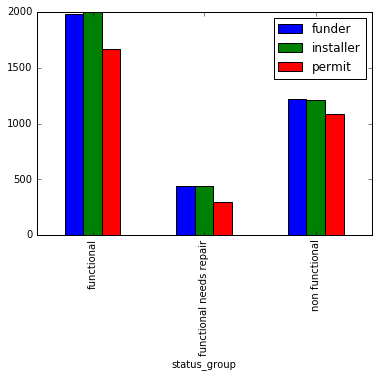

In [25]:
# Missing funder installer 
df_train.isnull().groupby(df_train['status_group']).sum()[['funder','installer','permit']].plot(kind='bar')


In [26]:
# For now dropping the funder, installer and subvillage columns -- would eventually like to use it 
df_train = df_train.drop(['funder','installer','subvillage'], axis=1)



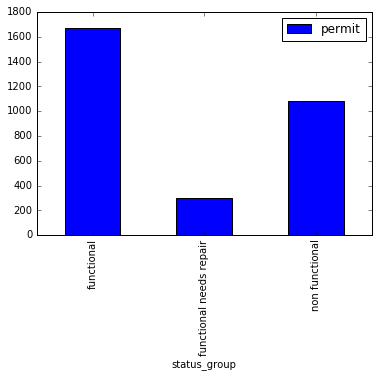

In [27]:
# Missing permit 
df_train.isnull().groupby(df_train['status_group']).sum()[['permit']].plot(kind='bar')


In [28]:
# isnull() dataframe and a series method --- inverse method notnull() 
# --- axis = 0 = do sum in the direction of the 0 axis/ across the rows/ down the columns
df_train.isnull().sum(axis=0)

# -- checking how many of these null valuses are in each of the subgroup labels
df_train.isnull().groupby(df_train['status_group']).sum()

# Dropping all the rows which has a missing value
df_train.dropna(how='any', inplace = True)

functional                 30586
non functional             21741
functional needs repair     4017
Name: status_group, dtype: int64


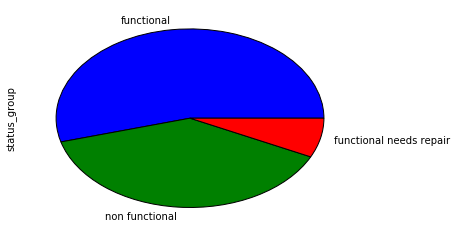

In [29]:
# observations under each category 

print(df_train['status_group'].value_counts())

df_train['status_group'].value_counts().plot(kind='pie')

# -- functional but needs repair has the least number of observations 

In [82]:
# creat a copy df for analysis

X2_names = ['id', 'amount_tsh','gps_height','basin', 'region', 
             'population', 'permit', 'extraction_type_group', 
            'management', 'payment_type', 'quality_group', 
             'quantity', 'source']

train2 = df_train.loc[:, X2_names]


In [83]:
# Rename long column names 

train2.rename(columns={'extraction_type_group':'extraction',
                       'payment_type':'payment',
                       'quality_group': 'quality'}, inplace=True)


In [84]:
train2.head()

,id,amount_tsh,gps_height,basin,region,population,permit,extraction,management,payment,quality,quantity,source
0,69572,6000.0,1390,Lake Nyasa,Iringa,109,False,gravity,vwc,annually,good,enough,spring
1,8776,0.0,1399,Lake Victoria,Mara,280,True,gravity,wug,never pay,good,insufficient,rainwater harvesting
2,34310,25.0,686,Pangani,Manyara,250,True,gravity,vwc,per bucket,good,enough,dam
3,67743,0.0,263,Ruvuma / Southern Coast,Mtwara,58,True,submersible,vwc,never pay,good,dry,machine dbh
4,19728,0.0,0,Lake Victoria,Kagera,0,True,gravity,other,never pay,good,seasonal,rainwater harvesting


In [85]:
X2 = pd.get_dummies(train2, drop_first=True)

In [86]:
X2.columns

Index(['id', 'amount_tsh', 'gps_height', 'population', 'basin_Lake Nyasa',
       'basin_Lake Rukwa', 'basin_Lake Tanganyika', 'basin_Lake Victoria',
       'basin_Pangani', 'basin_Rufiji', 'basin_Ruvuma / Southern Coast',
       'basin_Wami / Ruvu', 'region_Dar es Salaam', 'region_Dodoma',
       'region_Iringa', 'region_Kagera', 'region_Kigoma', 'region_Kilimanjaro',
       'region_Lindi', 'region_Manyara', 'region_Mara', 'region_Mbeya',
       'region_Morogoro', 'region_Mtwara', 'region_Mwanza', 'region_Pwani',
       'region_Rukwa', 'region_Ruvuma', 'region_Shinyanga', 'region_Singida',
       'region_Tabora', 'region_Tanga', 'permit_True', 'extraction_gravity',
       'extraction_india mark ii', 'extraction_india mark iii',
       'extraction_mono', 'extraction_nira/tanira', 'extraction_other',
       'extraction_other handpump', 'extraction_other motorpump',
       'extraction_rope pump', 'extraction_submersible', 'extraction_swn 80',
       'extraction_wind-powered', 'management

In [107]:
# target 
y2 = df_train.loc[:,['status_group']]

In [123]:
# functional -- 0; functional needs repair -- 1; non functional -- 2

y2 = y2['status_group'].astype('category').cat.codes


In [125]:
# Multinomial
logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')

# Create an instance of Logistic Regression Classifier and fit the data.
result = logreg.fit(X2, y2)


In [115]:
X2.columns[1:]

Index(['amount_tsh', 'gps_height', 'population', 'basin_Lake Nyasa',
       'basin_Lake Rukwa', 'basin_Lake Tanganyika', 'basin_Lake Victoria',
       'basin_Pangani', 'basin_Rufiji', 'basin_Ruvuma / Southern Coast',
       'basin_Wami / Ruvu', 'region_Dar es Salaam', 'region_Dodoma',
       'region_Iringa', 'region_Kagera', 'region_Kigoma', 'region_Kilimanjaro',
       'region_Lindi', 'region_Manyara', 'region_Mara', 'region_Mbeya',
       'region_Morogoro', 'region_Mtwara', 'region_Mwanza', 'region_Pwani',
       'region_Rukwa', 'region_Ruvuma', 'region_Shinyanga', 'region_Singida',
       'region_Tabora', 'region_Tanga', 'permit_True', 'extraction_gravity',
       'extraction_india mark ii', 'extraction_india mark iii',
       'extraction_mono', 'extraction_nira/tanira', 'extraction_other',
       'extraction_other handpump', 'extraction_other motorpump',
       'extraction_rope pump', 'extraction_submersible', 'extraction_swn 80',
       'extraction_wind-powered', 'management_other

In [141]:
# # create categorical variables 

# # For basin 

#train2["status_group"] = train2["status_group"].astype('category')

# train2["basin_cat"] = train2["basin"].cat.codes

# # For region 
# train2["region"] = train2["region"].astype('category')
# train2["region_cat"] = train2["region"].cat.codes

# # For region 
# train2["permit"] = train2["permit"].astype('category')
# train2["permit_cat"] = train2["permit"].cat.codes


In [ ]:
# dropna - dataframe method , .dropna(how='any', inplace = FALSE) - drop a rown if any of its values are missing 
#df_train.describe()
#df_train['status_group'].value_counts()
#df_train.select_dtypes(include=['object'])
#df_train[df_train.isnull().any(axis=1)]

In [ ]:
# convert 'date_recorded' to datetime 
#df_train['date_recorded'] = pd.to_datetime(df_train['date_recorded'])

#df_train.groupby(['status_group','funder']).size().nlargest(20)

#funder_name = df_train['funder'].value_counts().index.tolist()
# df_train.corr(method ='pearson')

In [ ]:
#df_train.dtypes
